Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [2]:
# Most IMPORTantly
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    # Drop columns related to social media 
    # Since we are looking for Great Burritos only
    df = df.drop(columns=['Yelp', 'Google'])
    
    # Drop Columns that are not included in less than ~2% of burritos
    cat_cutoff = 415
    cols_to_drop = [col for col in df.select_dtypes('object').columns if df[col].isnull().sum() > cat_cutoff]
    df.drop(columns= cols_to_drop, inplace=True)

    # Remove other redundant or unecessary categories
    # We are dropping length and circumference since they are used to calculate Volume
    df = df.drop(columns=['Chips', 'Mass (g)', 'Density (g/mL)', 'Unreliable', 'Fries', 'Queso', 'Length', 'Circum', 'NonSD', 'Reviewer'] )
    
    # Write a function to turn NaN values into zeros and x/X values into ones
    df = df.fillna(0)
    df = df.replace(['X', 'x'], 1)
    #df['Volume'] = df['Volume'].replace(0, np.NaN)

    df = df.drop(columns= ['Burrito'])

    # ----------STRETCH GOAL------------- 
    # ohe = OneHotEncoder(use_cat_names=True)
    # df = ohe.fit_transform(df)
    
    # SimpleImputer().fit(df)
    
    
    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [13]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [14]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

df.head()

,Cost,Hunger,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Beef,Pico,Guac,Cheese,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Pineapple,Avocado,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [15]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.
df.head()

# Look for Null values 
df.info()
df.isna().sum().sort_values(ascending=False)

df['Volume'].value_counts().sort_values()
df['Volume'].isna().sum()
df['Great'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cost          421 non-null    float64
 1   Hunger        421 non-null    float64
 2   Volume        421 non-null    float64
 3   Tortilla      421 non-null    float64
 4   Temp          421 non-null    float64
 5   Meat          421 non-null    float64
 6   Fillings      421 non-null    float64
 7   Meat:filling  421 non-null    float64
 8   Uniformity    421 non-null    float64
 9   Salsa         421 non-null    float64
 10  Synergy       421 non-null    float64
 11  Wrap          421 non-null    float64
 12  Beef          421 non-null    int64  
 13  Pico          421 non-null    int64  
 14  Guac          421 non-null    int64  
 15  Cheese        421 non-null    int64  
 16  Sour cream    421 non-null    int64  
 17  Pork          421 non-null    int64  
 18  Chicken    

0    0.567696
1    0.432304
Name: Great, dtype: float64

In [ ]:
# Work for the stretch Goal
df['Burrito'].value_counts()
df['Burrito'].describe()

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [22]:
target= 'Great'

X = df.drop(columns=target)
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [23]:
# Do some eda to determine the year ranges we are working with 
print(df.index.year.min())
print(df.index.year.max())

2011
2026


In [24]:
# Create and apply a mask to get the date ranges you want.
range_train = 2016
range_test = 2018
mask_train = (X.index.year >= range_train) & (X.index.year < range_test)
mask_test = (X.index.year >= range_test)

X_train, y_train = X.loc[mask_train], y.loc[mask_train]
X_test, y_test = X.loc[mask_test], y.loc[mask_test]

In [25]:
# Check the shape of each set
print(X_train.shape)
print(X_test.shape)
print(X_train.head())

(381, 33)
(38, 33)
            Cost  Hunger  Volume  Tortilla  ...  Cilantro  Onion  Pineapple  Avocado
Date                                        ...                                     
2016-01-18  6.49     3.0     0.0       3.0  ...         0      0          0        0
2016-01-24  5.45     3.5     0.0       2.0  ...         0      0          0        0
2016-01-24  4.85     1.5     0.0       3.0  ...         0      0          0        0
2016-01-24  5.25     2.0     0.0       3.0  ...         0      0          0        0
2016-01-27  6.59     4.0     0.0       4.0  ...         0      0          0        0

[5 rows x 33 columns]


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [32]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5826771653543307


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [33]:
model_logr = make_pipeline(OneHotEncoder(use_cat_names=True),
                           SimpleImputer(strategy='mean'),
                           StandardScaler(),
                           LogisticRegression())
model_logr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [34]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.8713910761154856
Test MAE: 0.7894736842105263


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

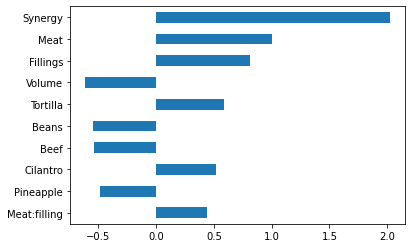

In [36]:
# Create your horizontal barchart here.

coefficients = model_logr.named_steps['logisticregression'].coef_[0]
features = model_logr.named_steps['onehotencoder'].get_feature_names()
feature_importance = pd.Series(coefficients, index= features).sort_values(key=abs)
feature_importance

feature_importance.tail(10).plot(kind= 'barh');

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [38]:
# Write code here to explore the differences between `predict` and `predict_proba`.
y_pred = model_logr.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1])

In [43]:
np.set_printoptions(suppress=True)
y_pred_prob = model_logr.predict_proba(X_test)
y_pred_prob

array([[0.00040953, 0.99959047],
       [0.00849687, 0.99150313],
       [0.9961651 , 0.0038349 ],
       [0.00006308, 0.99993692],
       [0.97096308, 0.02903692],
       [0.95286934, 0.04713066],
       [0.20546101, 0.79453899],
       [0.00598474, 0.99401526],
       [0.62537325, 0.37462675],
       [0.24595556, 0.75404444],
       [0.92487509, 0.07512491],
       [0.99358502, 0.00641498],
       [0.47926479, 0.52073521],
       [0.49569008, 0.50430992],
       [0.08611696, 0.91388304],
       [0.14801261, 0.85198739],
       [0.25393341, 0.74606659],
       [0.97201564, 0.02798436],
       [0.96832892, 0.03167108],
       [0.97648888, 0.02351112],
       [0.9503563 , 0.0496437 ],
       [0.0473564 , 0.9526436 ],
       [0.88487138, 0.11512862],
       [0.25571647, 0.74428353],
       [0.09487798, 0.90512202],
       [0.76100441, 0.23899559],
       [0.99935952, 0.00064048],
       [0.00052693, 0.99947307],
       [0.02702081, 0.97297919],
       [0.00639541, 0.99360459],
       [0.

**Give your written answer here:**
The .predict() method will return a binary prediction of 1 or 0, based on your model. 
```
The .predict() method will return a binary prediction of 1 or 0, based on your model. 

The .predict_proba() method will return the probability of your output being 1 or 0, which can be read as a percentage.


```